In [1]:
import os

In [2]:
from distributed.security import Security
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [3]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import HTCondorCluster
from dask_jobqueue.htcondor import HTCondorJob

In [4]:
fileset = {
    'Jets': { 'files': ['root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root'],
             'treename': 'Events'
            }
}

In [5]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change). It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.
# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class METProcessor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        self._columns = ['MET_pt']
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })

    @property
    def accumulator(self):
        return self._accumulator

    @property
    def columns(self):
        return self._columns

    def process(self, df):
        output = self.accumulator.identity()
        # This is where we do our actual analysis. The df has dict keys equivalent to the TTree's.
        dataset = df['dataset']
        MET = df['MET_pt']
        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += MET.size
        output['cutflow']['number of chunks'] += 1
        # This fills our histogram once our data is collected. Always use .flatten() to make sure the array is reduced. The output key will be as defined in __init__ for self._accumulator; the hist key ('MET=') will be defined in the bin.
        output['MET'].fill(dataset=dataset, MET=MET.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
sec_dask = Security(tls_ca_file='/etc/cmsaf-secrets/ca.pem',
               tls_worker_cert='/etc/cmsaf-secrets/usercert.pem',
               tls_worker_key='/etc/cmsaf-secrets/userkey.pem',
               tls_scheduler_cert='/etc/cmsaf-secrets/hostcert.pem',
               tls_scheduler_key='/etc/cmsaf-secrets/hostkey.pem',
               require_encryption=True)

In [7]:
HTCondorJob.submit_command = "condor_submit -spool"

In [8]:
cluster = HTCondorCluster(cores=4,
                          memory="2GB",
                          disk="1GB",
                          log_directory="logs",
                          silence_logs="debug",
                          scheduler_options= {"dashboard_address":"8786","port":8787, "external_address": "129.93.183.33:8787"},
                          # HTCondor submit script
                          job_extra={"universe": "docker",
                                     # To be used with coffea-casa:0.1.4
                                     "encrypt_input_files": "/etc/cmsaf-secrets/xcache_token",
                                     #"docker_network_type": "host",
                                     "docker_image": "oshadura/coffea-casa-analysis:0.1.6", 
                                     "container_service_names": "dask",
                                     "dask_container_port": "8787",
                                     "should_transfer_files": "YES",
                                     "when_to_transfer_output": "ON_EXIT",
                                     "+DaskSchedulerAddress": '"129.93.183.33:8787"',
                                    })

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://192.168.37.242:8787
distributed.scheduler - INFO -   dashboard at:                     :8786


In [9]:
cluster.scale(jobs=2)

In [10]:
client = Client(cluster)#, security=sec_dask)

distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Receive client connection: Client-b0400b68-a3ed-11ea-822a-4e978354f915
distributed.core - INFO - Starting established connection


In [11]:
#cachestrategy = 'dask-worker'
exe_args = {
        'client': client,
        #'cachestrategy': cachestrategy,
        #'savemetrics': True,
        #'worker_affinity': True if cachestrategy is not None else False,
    }
output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = METProcessor(),
                                executor = processor.dask_executor,
                                executor_args = exe_args
                                )

[                                        ] | 0% Completed | 34.7s

distributed.scheduler - INFO - Register worker <Worker 'tcp://129.93.182.24:32776', name: htcondor--2633875.0--, memory: 0, processing: 1>
distributed.scheduler - INFO - Starting worker compute stream, tcp://129.93.182.24:32776
distributed.core - INFO - Starting established connection


[####                                    ] | 10% Completed | 33.4ss

distributed.scheduler - INFO - Register worker <Worker 'tcp://129.93.183.92:32800', name: htcondor--2633876.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://129.93.183.92:32800
distributed.core - INFO - Starting established connection


/opt/conda/lib/python3.7/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


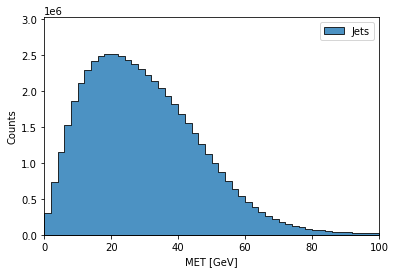

In [12]:
# Generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional, to fill the graph (default is a line).
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [13]:
# Easy way to print all cutflow dict values. Can just do print(output['cutflow']["KEY_NAME"]) for one.
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of chunks 534
